# Sentiment Analysis for the Bitcoins 

![](https://upload.wikimedia.org/wikipedia/commons/c/c5/Bitcoin_logo.svg)

In the first notebook [StockTwit](https://nbviewer.jupyter.org/github/thomaspernet/PythonFinanceClass/blob/master/FinancialProject.ipynb), we created a robot using Stocktwit API to automatically collect the messages related to the Bitcoins.

In this notebook, we are going to use those data to run a sentiment analysis. More specifically, the aim is to answer the question:

- What is the relation between investor sentiment on social media and stock market returns? Any predictive power?

## Agenda

We will proceed as follow:

1. Create a function to clean the corpus
2. Create a brief text analysis
2. Evaluate the sentiment using the L2 method
3. Evaluate the sentiment using the L1 method
4. Evaluate the sentiment using a machine learning method
5. Predicg out of sample
6. Get Bitcoin data
7. Run the Granger test on Bitcoin's return and sentiment

Related paper: [Intraday online investor sentiment and return patterns in the U.S.
stock market](https://docs.google.com/file/d/1L8bS8vNTXS-HWToP4zMpqfT308n-LxZb/edit)

L1/L2 Lexicon: [here](http://www.thomas-renault.com/data.php)

In [1]:
import pandas as pd
import numpy as np
import pymongo
from pymongo import MongoClient
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [2]:
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('stopwords')

# Clean the corps

We create a function named `metatransformation` to prepare the data.

Note that, we only care about the sentiment either `Bullish` or `Bearish` and remove multiple stock twits

## Workflow of the function

Step 1: 

    - Extract the data from MonGoDb using the `query` argument of the function
    
Step :2
       
    - Exclude multi tickers

Step :3
       
    - take negation into account and add prefix `negtag_:
       
       - "not","no","none","neither","never" or “nobody”

Step :3
    
    - Further clean up as follow:
        - Convert digit to "numbertag"        
        - Remove @USER
        - Remove ticker
        - Remove special characters
        - lower the text

Step 4: 

    - Remove stop words

Below some example of stop words

In [3]:
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Step 4: 

    - Lemmanize
    
Step 5: 

    - Create train/test set
    
### note about Lemmatization

Lemmatization reduces words to their base word, which is linguistically correct lemmas. It transforms root word with the use of vocabulary and morphological analysis. Lemmatization is usually more sophisticated than stemming. Stemmer works on an individual word without knowledge of the context. For example, The word "better" has "good" as its lemma. This thing will miss by stemming because it requires a dictionary look-up

### Define MetaFunction

The function below clean and lemmanize the corpus and return a train/test set

In [4]:
def metatransformation(client, db, query, to_train=True):
    """
    Arguments:
    Query: MongoDB query 
    to_train:  True: return a train and test dataset
    False: return only data to predict out of sample
    
    Step :1
        - Extract the data from MonGoDb
        
    Step 2:
        - Exclude multi tickers

    Step :3
        - take negation into account:
            - "not","no","none","neither","never" or “nobody”
        - Convert digit to "numbertag"        
        - Remove @USER
        - Remove ticker
        - Remove special characters
        - Lower test

    Step 4: Remove stop words
    Step 5: Lemmanize
    Step 6: Train/test set

    """

    text = pd.DataFrame(list(db.messages.find(query)))

    # Count stock

    text["count_stock"] = text["symbols"].apply(lambda x: len(x))

    # Extract single count

    text = text[text["count_stock"].isin([1])]

    # take negation into account
    # Convert digit to "_digit"
    # Remove @USER
    # Remove unicode issue
    # Remove ticker
    # Remove all the special characters
    # remove all single characters
    # Remove Ya
    # Remove bitcoin
    # remove btc
    text["body_transform"] = text["body"].replace(
        regex={
            r"\bnothing\b": "negtag_nothing",
            r"\bno\b": "negtag_no",
            r"\bnone\b": "negtag_none",
            r"\bneither\b": "negtag_neither",
            r"\bnever\b": "negtag_never",
            r"\bnobody\b": "negtag_nobody",
            r"\d+": "numbertag ",
            r"([@?])(\w+)\b": "user",
            r"\b&#\b": " ",
            r"[$][A-Za-z][\S]*": "",
            r"\W": " ",
            r"\s+[a-zA-Z]\s+": " ",
            r"\^[a-zA-Z]\s+": " ",
            r"\s+": " ",
            r"^b\s+": "",
            r"\bya\b": "",
            r"\bbitcoin\b": "",
            r"\bBitcoin\b": "",
            r"\bbtc\b": "",
        }
    )
    # Lower

    text["body_transform"] = text["body_transform"].str.lower()

    # Remove stop words

    stop = stopwords.words('english')

    text["body_transform"] = text["body_transform"].apply(
        lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    # Lemmatize

    lemmatizer = WordNetLemmatizer()
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

    text["body_transform"] = text["body_transform"].apply(
        lambda x: " ".join([lemmatizer.lemmatize(w)
                            for w in w_tokenizer.tokenize(x)])
    )

    # Split the dataset

    X_ = text["body_transform"]
    y_ = text["sentiment_"]

    count_ = text.groupby("sentiment")["sentiment"].count()

    print("The shape of the data is {}, and {}".format(text.shape, count_))

    if to_train:
        X_train, X_test, y_train, y_test = train_test_split(
            X_, y_, test_size=0.1, random_state=0
        )

        return X_train, X_test, y_train, y_test

    else:

        return X_

# Preliminary analysis

Make brief plots of the frequency count, distribution of keywords by sentiment and bigrams frequency

In [5]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

In [6]:
client = MongoClient('localhost', 27017)

### Client is the database
db = client['StockTwitClass101']

In [7]:
query ={
    "sentiment":{ "$ne": "Neutral" }
}
X_train, X_test, y_train, y_test = metatransformation(client, db,
    query = query)

The shape of the data is (76507, 10), and sentiment
Bearish    22110
Bullish    54397
Name: sentiment, dtype: int64


Example of message

In [8]:
X_train.iloc[0]

'another dump right numbertag k coming morning'

In [9]:
y_train.iloc[0]

-1

Sentiments distribtion in the train set. Highly unbalanced

In [10]:
y_train.reset_index().groupby('sentiment_')['sentiment_'].count()

sentiment_
-1    19895
 1    48961
Name: sentiment_, dtype: int64

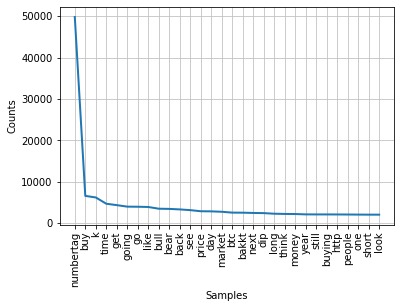

In [11]:
Word_tokenize = X_train.apply(word_tokenize) 
### Need to flatten the list
flattened_list = [y for x in Word_tokenize.tolist() for y in x]
fdist = FreqDist(flattened_list)
fdist.plot(30,cumulative=False)
plt.show()

In [12]:
def plot_keyword_sentiment(df, nbKeyword= 10):
    """
    Plot the distribution of sentiments by keyword
    """
    
    df_fdist = pd.DataFrame.from_dict(df, orient='index')
    df_fdist.columns = ['Frequency']
    df_fdist.index.name = 'Term'
    df_fdist =df_fdist.sort_values(by = 'Frequency', ascending = False)
    
    ### 
    
    df_top_sent = pd.DataFrame()
    for key in df_fdist.head(nbKeyword).index:

        count_sentiment = (
            pd.concat([X_train[X_train.str.contains(key)],
                             y_train], axis = 1, join = 'inner')
            .groupby('sentiment_')['body_transform']
            .count()
            .reset_index()
        )
        count_sentiment['keyword'] = key
        df_top_sent = df_top_sent.append(count_sentiment)
    df_top_sent = df_top_sent.pivot(index='keyword',
                  columns='sentiment_',
                  values='body_transform')
    df_top_sent['sum'] = df_top_sent.apply(lambda x: x.sum(), axis = 1)
    df_top_sent.sort_values(by = 'sum').drop(columns = 'sum').plot.barh(stacked=True)

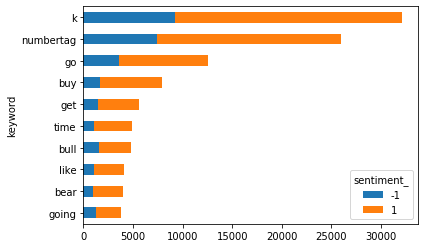

In [13]:
plot_keyword_sentiment(df = fdist, nbKeyword= 10)

## Bigrams

Definitelly needs to clean more the corpus..

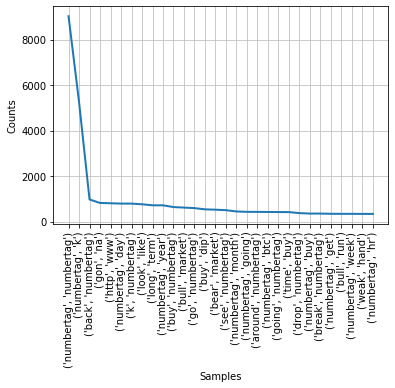

In [14]:
bgs = nltk.ngrams(flattened_list, 2)

fdist = nltk.FreqDist(bgs)

fdist.plot(30,cumulative=False)
plt.show()

# L2 Approach

In [15]:
L2 = pd.read_csv('http://www.thomas-renault.com/l2_lexicon.csv',
           sep = ";")
L2.head(3)

,keyword,sentiment
0,+,positive
1,above,positive
2,accumulate,positive


In [16]:
list_pos = L2[L2['sentiment'].isin(['positive'])]['keyword'].tolist()
list_neg = L2[L2['sentiment'].isin(['negative'])]['keyword'].tolist()

In [17]:
def sentiment_L2(x):

    """
    Compute the average sentiment,
    given a list L2
    """
    sentiment = 0
    text = word_tokenize(x)
    for x in text:
        if x in list_pos:
            sentiment += 1
        elif x in list_neg:
            sentiment += -1
            
    try:
        avg_sentiment = sentiment / len(text)
    except:
        avg_sentiment = 0
            
    return avg_sentiment

Example of message

In [18]:
X_train.iloc[0]

'another dump right numbertag k coming morning'

The L2 lexicon correctly classified it as Bearish

In [19]:
sentiment_L2(x = X_train.iloc[0])

-0.14285714285714285

Issue with the 0, classify as bearish. The cleaned corpus does not 100% match the L2 lexicon. For instance, open the second message in the test set. 

In [20]:
X_test.iloc[1]

'got bakkt'

There is no `got` in the lexicon. 

In [21]:
y_pred = X_test.apply(sentiment_L2)
y_pred.head()

15209    0.250000
64977    0.000000
73139    0.043478
45321    0.000000
11178    0.000000
Name: body_transform, dtype: float64

Remove unclassified messages 

In [22]:
y_pred = y_pred[y_pred !=0]
y_pred.shape

(3750,)

In [23]:
y_pred_ = np.where(y_pred > 0, 1, -1)
print(metrics.classification_report(y_test[y_test.index.isin(y_pred.index)],
                                    y_pred_))

              precision    recall  f1-score   support

          -1       0.47      0.77      0.58      1098
           1       0.87      0.63      0.73      2652

    accuracy                           0.67      3750
   macro avg       0.67      0.70      0.66      3750
weighted avg       0.75      0.67      0.69      3750



In [24]:
metrics.confusion_matrix(y_test[y_test.index.isin(y_pred.index)],
                         y_pred_)

array([[ 846,  252],
       [ 971, 1681]])

# L1 Approach

In [25]:
L1 = pd.read_csv('http://www.thomas-renault.com/l1_lexicon.csv',
           sep = ";")
L1.head(3)

,keyword,sw
0,up,0.233285
1,short,-0.581160
2,down,-0.462716


In [26]:
L1_keywords = L1['keyword'].tolist()
L1_weights = L1['sw'].tolist()

In [27]:
def sentiment_L1(x):
    """
    Compute the average sentiment,
    given a list L1
    """


    sentiment = 0
    text = word_tokenize(x)
    for x in text:
        if x in L1_keywords:
        # find index
            index = L1_keywords.index(x)
            wg = L1_weights[index]
            sentiment += wg

    try:
        avg_sentiment = sentiment / len(text)
    except:
        avg_sentiment = 0

    return avg_sentiment

In [28]:
X_train.iloc[0]

'another dump right numbertag k coming morning'

In [29]:
sentiment_L1(X_train.iloc[0])

-0.07582478794299999

In [30]:
y_pred = X_test.apply(sentiment_L1)
y_pred.head()

15209    0.101329
64977    0.000000
73139   -0.017188
45321    0.000000
11178    0.000000
Name: body_transform, dtype: float64

In [31]:
y_pred = y_pred[y_pred !=0]
y_pred.shape

(5259,)

In [32]:
y_pred_ = np.where(y_pred > 0, 1, -1)
print(metrics.classification_report(y_test[y_test.index.isin(y_pred.index)],
                                    y_pred_))

              precision    recall  f1-score   support

          -1       0.41      0.73      0.53      1533
           1       0.84      0.57      0.68      3726

    accuracy                           0.62      5259
   macro avg       0.62      0.65      0.60      5259
weighted avg       0.71      0.62      0.63      5259



In [33]:
metrics.confusion_matrix(y_test[y_test.index.isin(y_pred.index)], 
                         y_pred_)

array([[1122,  411],
       [1605, 2121]])

# Machine Learning Approach

This step includes:

- Build the Vectorization
- Construct the Naive classifier

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [35]:
text_clf = Pipeline([
    ('vect', CountVectorizer(max_features=1500,
                             min_df=10,
                             max_df=0.7)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
 ])

Create the first transformation of the data

## Fit the model

In [36]:
text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.7,
                                 max_features=1500, min_df=10,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

Predict first message

In [37]:
X_train.iloc[0]

'another dump right numbertag k coming morning'

In [38]:
text_clf.predict(X_train)[0]

-1

Test the accuracy of the model

In [39]:
predicted = text_clf.predict(X_test)

print(metrics.classification_report(y_test,
                                    predicted))

              precision    recall  f1-score   support

          -1       0.84      0.34      0.48      2215
           1       0.78      0.97      0.87      5436

    accuracy                           0.79      7651
   macro avg       0.81      0.66      0.67      7651
weighted avg       0.80      0.79      0.76      7651



In [40]:
metrics.confusion_matrix(y_test, predicted)

array([[ 747, 1468],
       [ 144, 5292]])

# Predict out of sample

Using ML method

In [41]:
query ={
    "sentiment":"Neutral" 
}
X_predict = metatransformation(client, db,
    query = query,
                               to_train = False)

The shape of the data is (63528, 10), and sentiment
Neutral    63528
Name: sentiment, dtype: int64


In [42]:
predicted = text_clf.predict(X_predict)

In [43]:
outofsample = pd.concat([pd.Series(X_predict, name = 'body').reset_index(),
          pd.Series(predicted, name = 'predict')], axis = 1)

The model really struggles to classify the bearish

In [44]:
outofsample.groupby('predict')['predict'].count()

predict
-1     5538
 1    57990
Name: predict, dtype: int64

Example

In [45]:
outofsample[outofsample['predict'].isin([1])].head(4)

,index,body,predict
0,0,bear get back numbertag k job put phone pocket,1
1,2,numbertag k,1
2,3,sadly look like leg leg,1
3,4,nice fly,1


In [46]:
outofsample[outofsample['predict'].isin([-1])].head(4)

,index,body,predict
33,37,look numbertag year chart look like still lot ...,-1
68,79,low trading right xnumbertag risky right large...,-1
69,80,real gold dumped woow,-1
77,95,prisoner moment vast majority people lose mone...,-1


## Get Bitcoins Data

Extracted from [Quandl](https://www.quandl.com/data/BCHAIN/MKPRU-Bitcoin-Market-Price-USD)

In [47]:
import quandl
quandl.ApiConfig.api_key = "gs_J3domJb8kT6WjLz9s"

In [48]:
bitcoin = quandl.get("BCHAIN/MKPRU")
bitcoin['returns'] = bitcoin.pct_change(1)
bitcoin.tail()

,Value,returns
Date,,
2019-09-26,8459.584167,-0.105451
2019-09-27,8257.246667,-0.023918
2019-09-28,8042.416667,-0.026017
2019-09-29,8154.111667,0.013888
2019-09-30,8086.552500,-0.008285


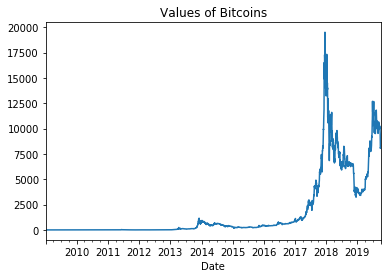

In [49]:
bitcoin['Value'].plot(title='Values of Bitcoins')

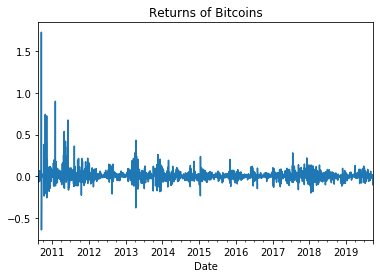

In [50]:
### Looks stationary
bitcoin['returns'].dropna().plot(title='Returns of Bitcoins')

## Daily aggregated sentiment

Compute the daily average: Only on messages we have the sentiments since our classifier is not very much reliable

In [51]:
query = {"sentiment": {"$ne": "Neutral"}}
text = pd.DataFrame(list(db.messages.find(query)))
text["created_at"] = pd.to_datetime(text["created_at"], infer_datetime_format=True)
text = (text
        .set_index("created_at")
        .drop(columns="id")
        .resample("D")
        .mean()
       )

In [52]:
timeseries = pd.concat([text, bitcoin], axis = 1, join="inner")

timeseries.head()

,sentiment_,Value,returns
2019-08-27,0.806452,10347.806667,0.023945
2019-08-28,0.250689,10176.794167,-0.016526
2019-08-29,0.281106,10039.112500,-0.013529
2019-08-30,0.497992,9521.571667,-0.051552
2019-08-31,0.661176,9539.253333,0.001857


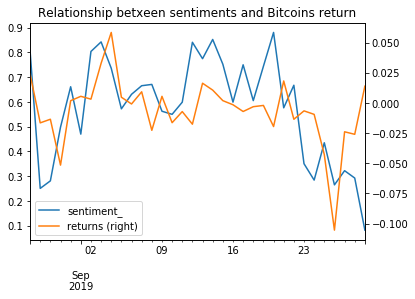

In [53]:
axw = timeseries[['sentiment_', 'returns']].plot(secondary_y = 'returns',
                      title='Relationship betxeen sentiments and Bitcoins return')
figw = axw.get_figure()

## Granger test

Test the Granger Causality between sentiment on social media and stock returns

### How does Granger causality test work?

It is based on the idea that if X causes Y, then the forecast of Y based on previous values of Y AND the previous values of X should outperform the forecast of Y based on previous values of Y alone.

According to Statsmodels 

The Null hypothesis for `grangercausalitytests` is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

The null hypothesis for all four test is that the coefficients corresponding to past values of the second time series are zero.

In [54]:
from statsmodels.tsa.stattools import grangercausalitytests

According to the results, we believe there is no granger causality from sentiment to returns, ie all p-values are all above .05, accepting the null hypothesis, the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1.

In [55]:
grangercausalitytests(timeseries[['returns', 'sentiment_']], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1812  , p=0.0118  , df_denom=30, df_num=1
ssr based chi2 test:   chi2=7.8994  , p=0.0049  , df=1
likelihood ratio test: chi2=7.0820  , p=0.0078  , df=1
parameter F test:         F=7.1812  , p=0.0118  , df_denom=30, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4197  , p=0.0219  , df_denom=27, df_num=2
ssr based chi2 test:   chi2=10.4764 , p=0.0053  , df=2
likelihood ratio test: chi2=9.0628  , p=0.0108  , df=2
parameter F test:         F=4.4197  , p=0.0219  , df_denom=27, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0873  , p=0.0177  , df_denom=24, df_num=3
ssr based chi2 test:   chi2=15.8383 , p=0.0012  , df=3
likelihood ratio test: chi2=12.7941 , p=0.0051  , df=3
parameter F test:         F=4.0873  , p=0.0177  , df_denom=24, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0080  , p=0.1302  , df_d

{1: ({'ssr_ftest': (7.181227503066568, 0.011846355265075752, 30.0, 1),
   'ssr_chi2test': (7.899350253373224, 0.004945255792934745, 1),
   'lrtest': (7.082018302606343, 0.007786126428315471, 1),
   'params_ftest': (7.181227503066577, 0.011846355265075699, 30.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.4197484232420745, 0.021853706845479975, 27.0, 2),
   'ssr_chi2test': (10.476440706944176, 0.005309697817859066, 2),
   'lrtest': (9.062837859912776, 0.010765389896085062, 2),
   'params_ftest': (4.419748423242084, 0.021853706845479843, 27.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.087302048497901, 0.01772756592818935, 24.0, 3),
   'ssr_chi2test': (15.838295437929368, 0.0012239125513905274, 3),
   'lrtest': (12.794132214997944, 0.005103632912955087, 3),
   'params_ftest': (4.087302048497903, 0.017727565928189318, 24.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.

## Regress

$$
r_{i, t}=\alpha+\beta_{1} \Delta s_{1, t}+\beta_{2} \Delta s_{i, t-1}+\epsilon_{t}
$$


In [56]:
timeseries['sentiment_lag'] = timeseries['sentiment_'].shift(1)

In [57]:
timeseries['L_s1'] = timeseries['sentiment_'].pct_change(1)
timeseries['L_s2'] = timeseries['sentiment_lag'].pct_change(1)
timeseries.head()

,sentiment_,Value,returns,sentiment_lag,L_s1,L_s2
2019-08-27,0.806452,10347.806667,0.023945,NaN,NaN,NaN
2019-08-28,0.250689,10176.794167,-0.016526,0.806452,-0.689146,NaN
2019-08-29,0.281106,10039.112500,-0.013529,0.250689,0.121335,-0.689146
2019-08-30,0.497992,9521.571667,-0.051552,0.281106,0.771545,0.121335
2019-08-31,0.661176,9539.253333,0.001857,0.497992,0.327685,0.771545


In [58]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [59]:
mod1 = smf.ols(formula='returns ~ L_s1 + L_s2', 
               data=timeseries).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                returns   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.5842
Date:                Mon, 30 Sep 2019   Prob (F-statistic):              0.564
Time:                        13:43:17   Log-Likelihood:                 70.911
No. Observations:                  32   AIC:                            -135.8
Df Residuals:                      29   BIC:                            -131.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0061      0.005     -1.247      0.222      -0.016       0.004
L_s1          -0.0168      0.016     -1.075      0.291      -0.049       0.015
L_s2          -0.0012      0.016     -0.076      0.940      -0.033       0.031
==============================================================================
Omnibus:                       24.584   Durbin-Watson:                   1.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.282
Skew:                          -1.510   Prob(JB):                     1.10e-14
Kurtosis:                       9.252   Cond. No.                         3.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$$
r_{i, t}=\alpha+ \beta_{1} \Delta s_{1, t}+ \beta_{2} \Delta s_{i, t-1}+ 
+\beta_{3} \Delta r_{1, t-1}+\beta_{4} \Delta r_{i, t-2}
+  \epsilon_{t}
$$

In [60]:
timeseries['returns_lag'] = timeseries['returns'].shift(1)
timeseries['L_r1'] = timeseries['returns'].pct_change(1)
timeseries['L_r2'] = timeseries['returns_lag'].pct_change(1)
timeseries.head()

,sentiment_,Value,returns,sentiment_lag,L_s1,L_s2,returns_lag,L_r1,L_r2
2019-08-27,0.806452,10347.806667,0.023945,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-28,0.250689,10176.794167,-0.016526,0.806452,-0.689146,NaN,0.023945,-1.690193,NaN
2019-08-29,0.281106,10039.112500,-0.013529,0.250689,0.121335,-0.689146,-0.016526,-0.181374,-1.690193
2019-08-30,0.497992,9521.571667,-0.051552,0.281106,0.771545,0.121335,-0.013529,2.810519,-0.181374
2019-08-31,0.661176,9539.253333,0.001857,0.497992,0.327685,0.771545,-0.051552,-1.036022,2.810519


In [61]:
mod1 = smf.ols(formula='returns ~ L_s1 + L_s2 +L_r1 + L_r2', 
               data=timeseries).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                returns   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                 -0.046
Method:                 Least Squares   F-statistic:                    0.6625
Date:                Mon, 30 Sep 2019   Prob (F-statistic):              0.623
Time:                        13:43:17   Log-Likelihood:                 71.777
No. Observations:                  32   AIC:                            -133.6
Df Residuals:                      27   BIC:                            -126.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0061      0.005     -1.223      0.232      -0.016       0.004
L_s1          -0.0133      0.016     -0.812      0.424      -0.047       0.020
L_s2          -0.0027      0.017     -0.162      0.872      -0.037       0.032
L_r1          -0.0007      0.002     -0.492      0.627      -0.004       0.002
L_r2           0.0017      0.001      1.162      0.255      -0.001       0.005
==============================================================================
Omnibus:                       31.805   Durbin-Watson:                   1.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.022
Skew:                          -1.990   Prob(JB):                     1.16e-22
Kurtosis:                      10.741   Cond. No.                         13.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Overall

## Shortcoming of the analysis

- Lack of data: 1 month data is not enough
- Lack of variance in the data: The data collected shows a biais toward bullish sentiment, even though the trend was declining
- Need to improve the cleaning of the corpus to match the L1/L2 lexicon
- NB model unable to predict the `bearish` messages.
- The poor data processing leads to a wrong model prediction both for the sentiment analysis and Granger causality. 
- No coefficients in the time series are coefficient, although the returns look stationary 

# Appendix: Details steps & analytics


### TF-IDF:  Our approach

As explained in the previous post, the tf-idf vectorization of a corpus of text documents assigns each word in a document a number that is proportional to its frequency in the document and inversely proportional to the number of documents in which it occurs

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [62]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

Compute the IDFs

Compute the TFIDF score

The higher the TF*IDF score (weight), the rarer the term and vice versa.

## VADER technique

In [63]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [64]:
sid = SentimentIntensityAnalyzer()

In [65]:
query ={
    "sentiment":{ "$ne": "Neutral" }
}
text = pd.DataFrame(list(db.messages.find(query)))
text.head()

,_id,body,created_at,id,sentiment,sentiment_,symbols,user
0,5d8e4264a840b5ab5bac84a0,$BTC.X the bottom is 7960...it is written,2019-09-27T17:09:13Z,178878941,Bullish,1,[Bitcoin BTC/USD],ricardotubbsvicelord
1,5d8e4264a840b5ab5bac84a2,$BTC.X When September futures expire this thin...,2019-09-27T17:08:38Z,178878838,Bullish,1,[Bitcoin BTC/USD],carlsagan
2,5d8e4264a840b5ab5bac84a3,$BTC.X consolidation from 11am to 3pm...then t...,2019-09-27T17:08:28Z,178878799,Bullish,1,[Bitcoin BTC/USD],ricardotubbsvicelord
3,5d8e4264a840b5ab5bac84a6,$BTC.X anyone that touches this virus is self ...,2019-09-27T17:06:32Z,178878448,Bearish,-1,[Bitcoin BTC/USD],Arudsky
4,5d8e4264a840b5ab5bac84a7,$BTC.X nothing but down for 6 months. But buy ...,2019-09-27T17:05:17Z,178878221,Bearish,-1,[Bitcoin BTC/USD],Arudsky


In [66]:
def exampleVADER(df,x =0):
    """
    message from Xtrain and return
    VADER sentiment scrore
    """
    print("- The message is the following \n {} \n- VADER classification \n {}".format(
        df.iloc[x],
        sid.polarity_scores(df.iloc[x])))

In [67]:
exampleVADER(df = text['body'],x = 0)

- The message is the following 
 $BTC.X the bottom is 7960...it is written 
- VADER classification 
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [68]:
exampleVADER(df = X_train,x = 0)

- The message is the following 
 another dump right numbertag k coming morning 
- VADER classification 
 {'neg': 0.342, 'neu': 0.658, 'pos': 0.0, 'compound': -0.3818}


In [69]:
for i in range(0, 5):
    exampleVADER(df = text['body'], x = i)

- The message is the following 
 $BTC.X the bottom is 7960...it is written 
- VADER classification 
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
- The message is the following 
 $BTC.X When September futures expire this thing is going to rocket to outer space. 8k support, right on the 200 MDA. 
- VADER classification 
 {'neg': 0.0, 'neu': 0.881, 'pos': 0.119, 'compound': 0.4019}
- The message is the following 
 $BTC.X consolidation from 11am to 3pm...then the ascending...mark this post... laugh now cry later to the bears😆 
- VADER classification 
 {'neg': 0.143, 'neu': 0.691, 'pos': 0.166, 'compound': 0.128}
- The message is the following 
 $BTC.X anyone that touches this virus is self destructive.. Transactions are up.. Up from what zero? 
- VADER classification 
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
- The message is the following 
 $BTC.X nothing but down for 6 months. But buy buy.. Say but to your family buy to all your savings 
- VADER classification 
 {'

In [70]:
for i in range(0, 5):
    exampleVADER(df = X_train, x = i)

- The message is the following 
 another dump right numbertag k coming morning 
- VADER classification 
 {'neg': 0.342, 'neu': 0.658, 'pos': 0.0, 'compound': -0.3818}
- The message is the following 
 happy friday bull 
- VADER classification 
 {'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'compound': 0.5719}
- The message is the following 
 bear reaction realized failed bringing lol 
- VADER classification 
 {'neg': 0.327, 'neu': 0.396, 'pos': 0.277, 'compound': -0.128}
- The message is the following 
 bought bottom winter numbertag numbertag profit numbertag per numbertag dwindling risky stuff 
- VADER classification 
 {'neg': 0.122, 'neu': 0.68, 'pos': 0.197, 'compound': 0.2732}
- The message is the following 
 numbertag min till takeoff 
- VADER classification 
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [71]:
summary = {"positive": 0, "neutral": 0, "negative": 0}
for x in text['body']:
    ss = sid.polarity_scores(x)
    if ss["compound"] == 0.0:
        summary["neutral"] += 1
    elif ss["compound"] > 0.0:
        summary["positive"] += 1
    else:
        summary["negative"] += 1

In [72]:
summary

{'positive': 26506, 'neutral': 39365, 'negative': 19024}

In [73]:
summary = {"positive": 0, "neutral": 0, "negative": 0}
for x in X_train:
    ss = sid.polarity_scores(x)
    if ss["compound"] == 0.0:
        summary["neutral"] += 1
    elif ss["compound"] > 0.0:
        summary["positive"] += 1
    else:
        summary["negative"] += 1

In [74]:
summary

{'positive': 22415, 'neutral': 31197, 'negative': 15244}

In [81]:
def vader_(x):
    
    """
    Get sentiment from Vader analysis
    """
    
    sentiment = sid.polarity_scores(x)
    
    if sentiment["compound"] == 0.0:
        sent_ = 0
    elif sentiment["compound"] > 0.0:
        sent_ = 1
    else:
        sent_ = -1
    
    return sent_

In [82]:
test = text['body'].apply(vader_)

In [85]:
test.head()

0    0
1    1
2    1
3    0
4    0
Name: body, dtype: int64